# Comparison of the models
@LuiseJedlitschka

We decided to train the following models: MLP, Random Forest, XGBoost.
We trained them on stratified 80/20 split and on leave-one-group-out splits (one dataset as testset each).
These trained models are being compared here in their accuracy using confusion matrices and metrics (precision, recall, f1).

In [8]:
import joblib
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import os

In [11]:
# load models per split and their label encoders
# important: splits 0-5 are the logo-splits, split 6 is the stratified split

test_dir = Path("../data/leave-one-group-out-split/splits/")
stratified_test_file = Path("../data/combined-data-stratified-split/test_data.tsv")

# list of all test data
test_files = list(test_dir.glob("test_split_*.tsv")) + [stratified_test_file]

test_data = {}
for test_file in test_files:
    # determine split number
    if "test_split_" in test_file.name:
        split_num = int(test_file.stem.split("_")[-1])
    else:
        split_num = 6  # stratified test file

    df = pd.read_csv(test_file, sep="\t")
    drop_cols = ["Unnamed: 0", "Geneid", "DNASequence", "classification_x"]
    if "group" in df.columns:
        drop_cols.append("group")
    feature_cols = df.drop(columns=drop_cols).columns
    le = LabelEncoder()
    le.fit(["early", "middle", "late"])
    X_test = df[feature_cols].copy()
    y_test = le.transform(df["classification_x"].copy())

    test_data[split_num] = (X_test, y_test, le)

=== Split 0 ===
Model mlp for split 0 not found.
Model randomforest for split 0 not found.


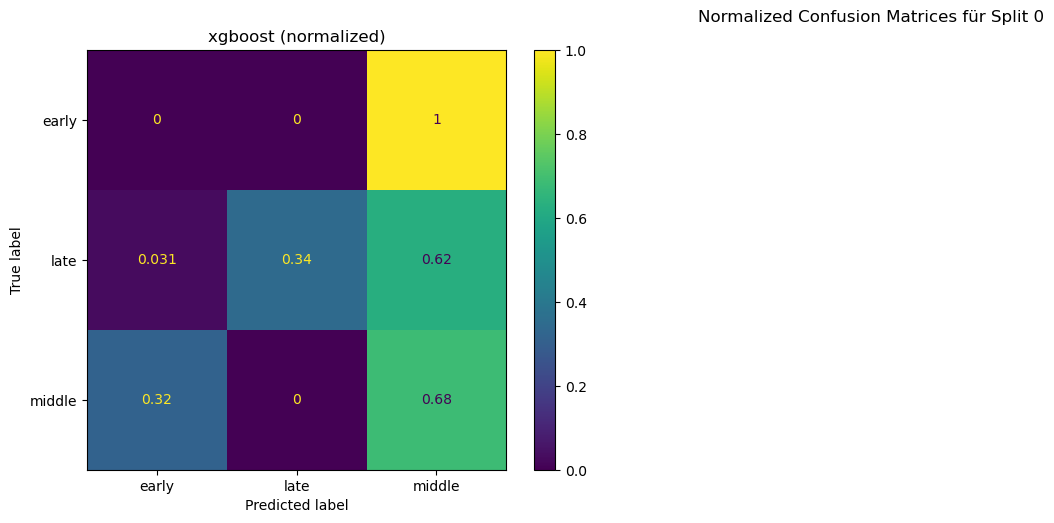

,Split,Model,Accuracy,Precision,Recall,F1
0,0,xgboost,0.444444,0.71965,0.444444,0.469517


=== Split 1 ===
Model mlp for split 1 not found.
Model randomforest for split 1 not found.


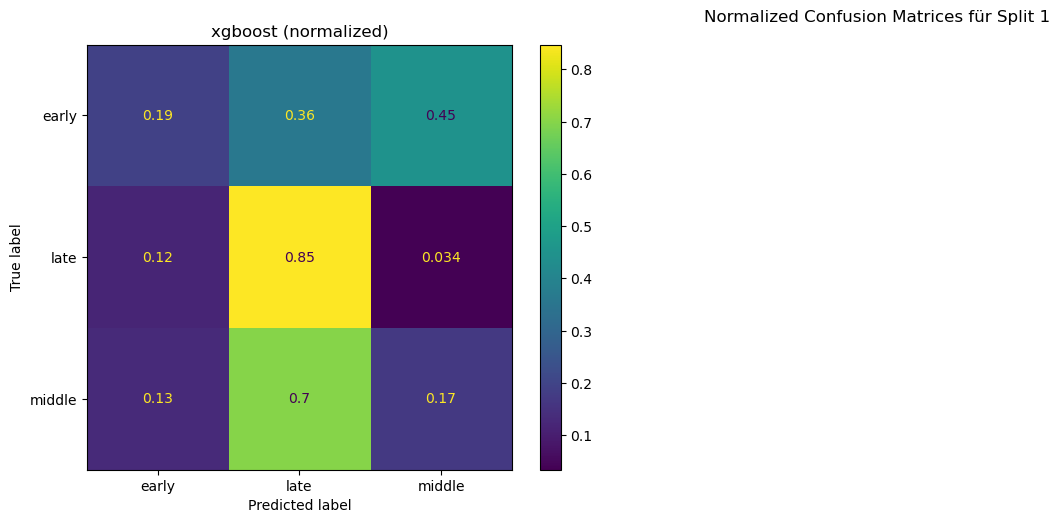

,Split,Model,Accuracy,Precision,Recall,F1
0,1,xgboost,0.345992,0.357985,0.345992,0.300795


=== Split 2 ===
Model mlp for split 2 not found.
Model randomforest for split 2 not found.


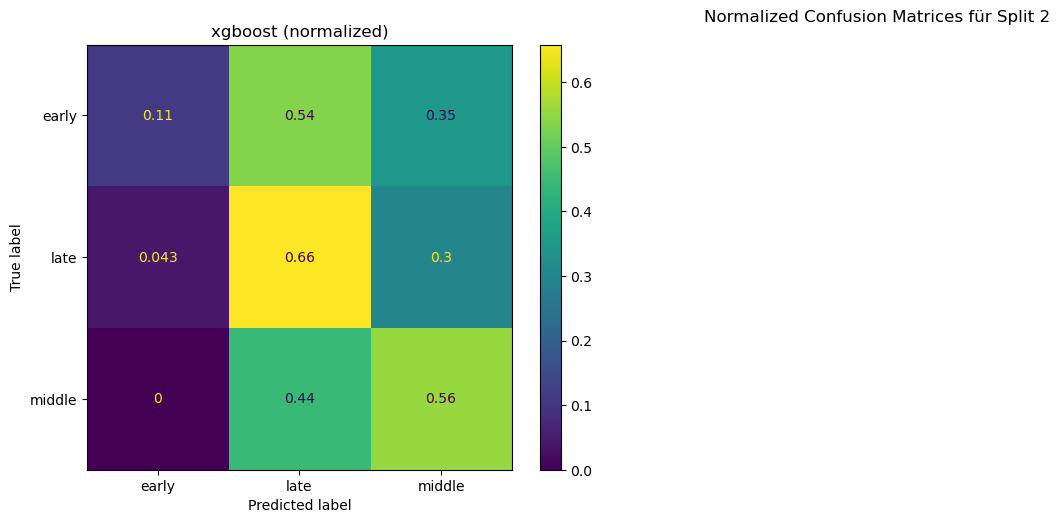

,Split,Model,Accuracy,Precision,Recall,F1
0,2,xgboost,0.347222,0.628026,0.347222,0.331925


=== Split 3 ===
Model mlp for split 3 not found.
Model randomforest for split 3 not found.


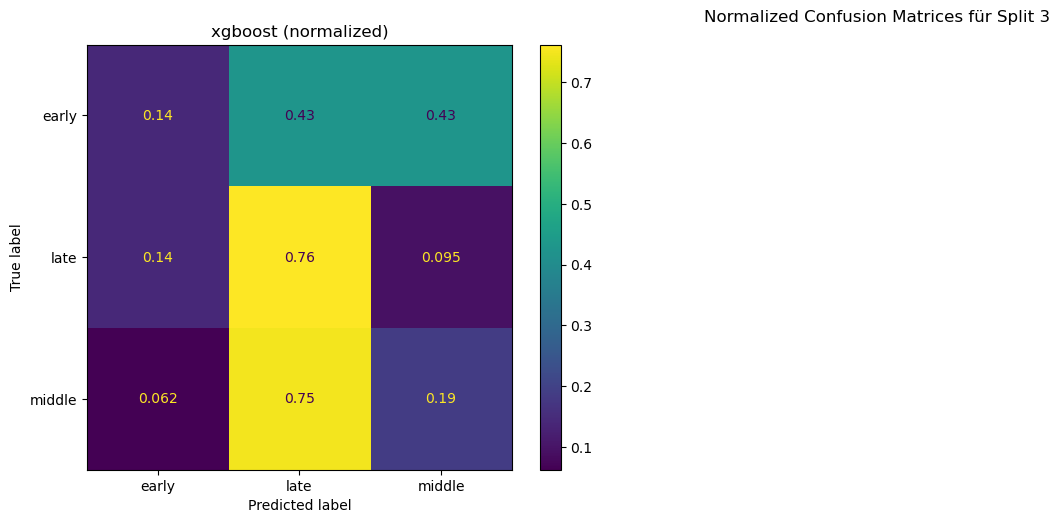

,Split,Model,Accuracy,Precision,Recall,F1
0,3,xgboost,0.383333,0.440586,0.383333,0.341786


=== Split 4 ===
Model mlp for split 4 not found.
Model randomforest for split 4 not found.


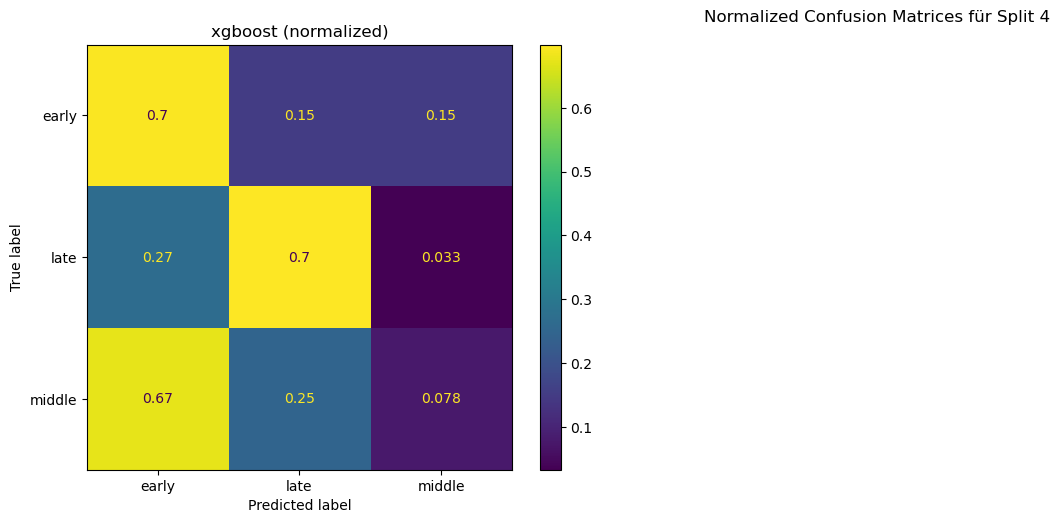

,Split,Model,Accuracy,Precision,Recall,F1
0,4,xgboost,0.420824,0.576854,0.420824,0.40452


=== Split 5 ===
Model mlp for split 5 not found.
Model randomforest for split 5 not found.


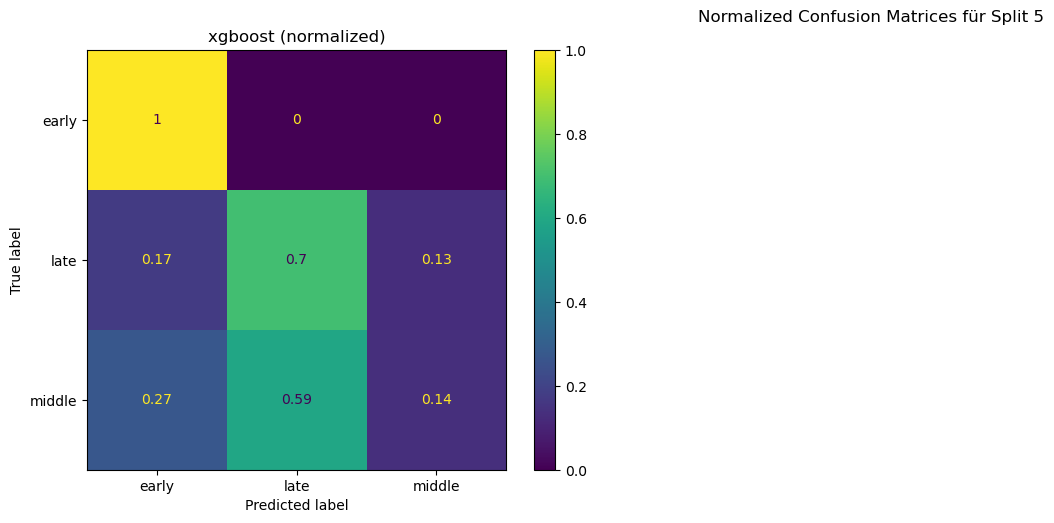

,Split,Model,Accuracy,Precision,Recall,F1
0,5,xgboost,0.518519,0.517645,0.518519,0.456553


=== Split 6 ===
Model mlp for split 6 not found.
Model randomforest for split 6 not found.


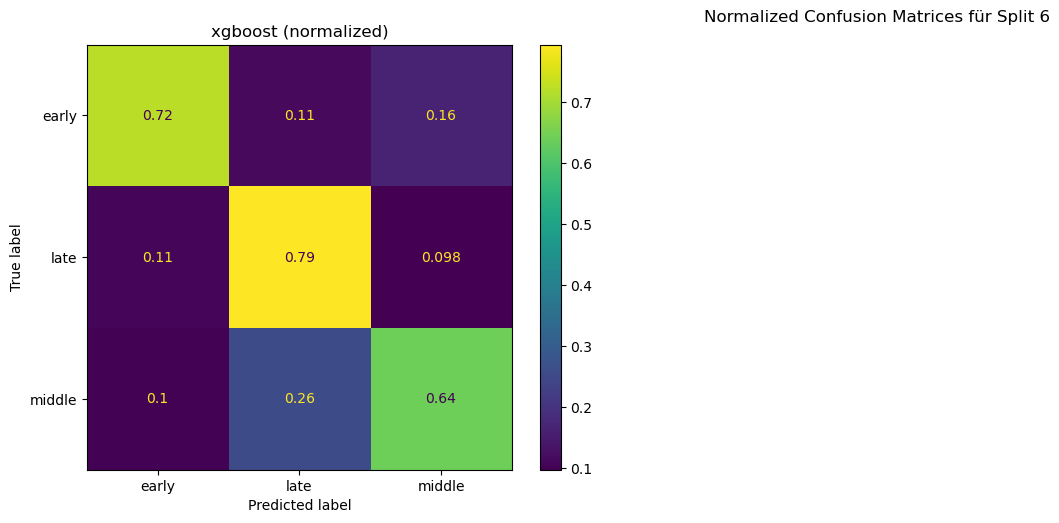

,Split,Model,Accuracy,Precision,Recall,F1
0,6,xgboost,0.722944,0.722823,0.722944,0.72148


,Split,Model,Accuracy,Precision,Recall,F1
0,0,xgboost,0.444444,0.719650,0.444444,0.469517
1,1,xgboost,0.345992,0.357985,0.345992,0.300795
2,2,xgboost,0.347222,0.628026,0.347222,0.331925
3,3,xgboost,0.383333,0.440586,0.383333,0.341786
4,4,xgboost,0.420824,0.576854,0.420824,0.404520
5,5,xgboost,0.518519,0.517645,0.518519,0.456553
6,6,xgboost,0.722944,0.722823,0.722944,0.721480


In [13]:
# important: save models per split as {model_name}_split_{split}

model_names = ["xgboost", "mlp", "randomforest"]
splits = range(7)  # 0-5 + stratified

all_results = []

for split in splits:
    print(f"=== Split {split} ===")
    fig, axes = plt.subplots(1, len(model_names), figsize=(6 * len(model_names), 5))
    metrics_list = []
    for i, name in enumerate(model_names):
        model_path = f"{name}_split_{split}.joblib"
        if not os.path.exists(model_path):
            print(f"Model {name} for split {split} not found.")
            if len(model_names) == 1:
                axes.set_visible(False)
            else:
                axes[i].set_visible(False)
            continue

        model = joblib.load(model_path)
        X_test, y_test, le = test_data[split]
        y_pred = model.predict(X_test)

        # Normalisierte Confusion Matrix
        ConfusionMatrixDisplay.from_estimator(
            model,
            X_test,
            y_test,
            display_labels=le.classes_,
            ax=axes[i],
            normalize="true"  # <--- HIER normalisieren
        )
        axes[i].set_title(f"{name} (normalized)")

        # calculate metrics
        metrics = {
            "Split": split,
            "Model": name,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred, average="weighted"),
            "Recall": recall_score(y_test, y_pred, average="weighted"),
            "F1": f1_score(y_test, y_pred, average="weighted"),
        }
        metrics_list.append(metrics)

    plt.suptitle(f"Normalized Confusion Matrices für Split {split}")
    plt.tight_layout()
    plt.show()

    if metrics_list:
        df_metrics = pd.DataFrame(metrics_list)
        display(df_metrics)
        all_results.extend(metrics_list)
    else:
        print("No models trained for this split.")

df_all = pd.DataFrame(all_results)
display(df_all)
